In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
cnt=1
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if(cnt==2):
            break
        print(os.path.join(dirname, filename))
        cnt+=1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-and-images-socal/socal2.csv


## Importing libraries

In [2]:
#importing libraries
import matplotlib.pyplot as plt
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, concatenate
from tensorflow.keras import Input

## Dataset

**We use the House Price dataset (socal) from kaggle for this problem.** 

**The csv file socal2.csv contains informations about a particular house like no. of bedrooms , bathrooms, kitchens, city code , square feet and price column.**

**We will drop the price column from the input data and this will act as the label value which we will predict finally from our model.**



**We also have a dataset of images where each image corresponds to one house.**

**Given below is the architecture of the model**

![Architecture of our model](https://drive.google.com/uc?export=view&id=1JWPszu8ZgxTdxCIJvtNbklkNIrfhqxFD)

In [3]:
df=pd.read_csv('/kaggle/input/house-prices-and-images-socal/socal2.csv')
print(df.head())

   image_id                 street             citi  n_citi  bed  bath  sqft  \
0         0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560   
1         1         124 C Street W      Brawley, CA      48    3   2.0   713   
2         2        2304 Clark Road     Imperial, CA     152    3   1.0   800   
3         3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
4         4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547   

    price  
0  201900  
1  228500  
2  273950  
3  350000  
4  385100  


In [4]:
X_house_attributes=df[['n_citi','bed','bath','sqft','price']]


print(X_house_attributes)
print(X_house_attributes.shape)

       n_citi  bed  bath  sqft   price
0         317    3   2.0  1560  201900
1          48    3   2.0   713  228500
2         152    3   1.0   800  273950
3          48    3   1.0  1082  350000
4          55    4   3.0  2547  385100
...       ...  ...   ...   ...     ...
15469     227    5   4.1  4092  949000
15470     372    5   3.0  2773  949900
15471     338    3   2.0  1576  920000
15472     253    4   2.0  2086  997000
15473     261    2   2.0  1216  975000

[15474 rows x 5 columns]
(15474, 5)


**X_house_attributes : contains the continous values**

## Data pre-processing

In [5]:

'''
columns:
n_citi : can be label encoded
bed : there are either 1,2,3,4,5 beds. can be label encoded
sqft : need to use minmax scaler
bath : use minmax scaler
price : also minmax scaler can be applied
'''

'\ncolumns:\nn_citi : can be label encoded\nbed : there are either 1,2,3,4,5 beds. can be label encoded\nsqft : need to use minmax scaler\nbath : use minmax scaler\nprice : also minmax scaler can be applied\n'

In [6]:
bm=max(X_house_attributes['bed'])
sqftm=max(X_house_attributes['sqft'])
pricem=max(X_house_attributes['price'])
bathm=max(X_house_attributes['bath'])
citim=max(X_house_attributes['n_citi'])
X_house_attributes['n_citi']=X_house_attributes['n_citi']/citim
X_house_attributes['bed']=X_house_attributes['bed']/bm
X_house_attributes['sqft']=X_house_attributes['sqft']/sqftm
X_house_attributes['bath']=X_house_attributes['bath']/bathm
X_house_attributes['price']=X_house_attributes['price']/pricem

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

**The size of images vary, so we will resize each image to a fixed size of 64X64**

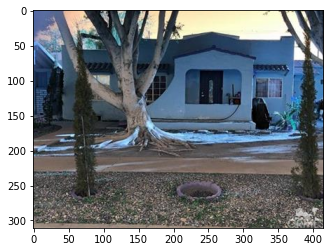

In [7]:
import cv2
sample=cv2.imread('/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/1.jpg')
plt.imshow(sample)

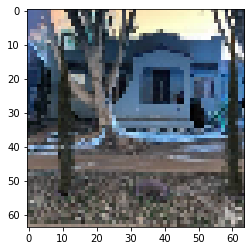

In [8]:
sample_resized=cv2.resize(sample,(64,64))
plt.imshow(sample_resized)

**Reading images sequentially**

In [9]:
import os
import cv2
cnt=0
images_path='../input/house-prices-and-images-socal/socal2/socal_pics'
X_house_images=np.zeros((15474,64,64,3),dtype='uint32')
for i in range(15474):

    sample=cv2.imread(images_path+'/'+str(i)+'.jpg')
    imgs=cv2.resize(sample,(64,64))
    X_house_images[cnt]=imgs
    cnt+=1

print("No. of images: ",cnt)

No. of images:  15474


In [10]:
X_house_images=X_house_images/255.0

**We will define 3 models.**

* **The ANN model will take the continous data and return vector of dimension 4 which will indicate features**

* **The CNN model will take images and return vector of dimension 4 which will indicate features**

* **Finally our final ANN model will take all these features and predict the final price.**

In [11]:
def create_ann(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    # return our model
    return model

In [12]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    #inpute shape: (64,64,3)
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    x = Dense(4)(x)
    x = Activation("relu")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

## Splitting into training and test set

In [13]:
# X_house_attributes -> continuous variables and price (output variable)
# X_house_images -> images
from sklearn.model_selection import train_test_split
split = train_test_split(X_house_attributes, X_house_images, test_size=0.25, random_state=42)
(Xatt_train,Xatt_test,Ximage_train,Ximage_test) = split

y_train , y_test = Xatt_train['price'].values , Xatt_test['price'].values

X1_train=Xatt_train[['n_citi','bed','bath','sqft']].values
X2_train=Ximage_train
X1_test=Xatt_test[['n_citi','bed','bath','sqft']].values
X2_test=Ximage_test

print(X1_train.shape)
print(X1_test.shape)
print(X2_train.shape)
print(X2_test.shape)
print(y_train.shape)
print(y_test.shape)

(11605, 4)
(3869, 4)
(11605, 64, 64, 3)
(3869, 64, 64, 3)
(11605,)
(3869,)


## Defining the model

In [14]:
# create the MLP and CNN models
mlp = create_ann(X1_train.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)



**We will give the X1_train as input to ANN, which has continous variables
and images (X2_train) to CNN.**

**Similarly for validation set**

In [15]:
from keras.optimizers import Adam
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mse", optimizer=opt)
# train the model
print("[INFO] training model...")

model.fit(x=[X1_train,X2_train], y=y_train,validation_data=([X1_test, X2_test], y_test),epochs=50, batch_size=64)


[INFO] training model...
Epoch 1/50
182/182 [==============================] - 3s 16ms/step - loss: 0.1217 - val_loss: 0.0425
Epoch 2/50
182/182 [==============================] - 2s 8ms/step - loss: 0.0377 - val_loss: 0.0476
Epoch 3/50
182/182 [==============================] - 2s 8ms/step - loss: 0.0353 - val_loss: 0.0364
Epoch 4/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0325 - val_loss: 0.0306
Epoch 5/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0276 - val_loss: 0.0252
Epoch 6/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 7/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 8/50
182/182 [==============================] - 2s 8ms/step - loss: 0.0226 - val_loss: 0.0233
Epoch 9/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0222 - val_loss: 0.0226
Epoch 10/50
182/182 [==============================] - 2s 9ms/step - loss:

## Prediction on a test data

**Taking image id 4 data**

In [16]:
attr_sample=df.loc[df['image_id'] == 4]
print(attr_sample)

   image_id                 street          citi  n_citi  bed  bath  sqft  \
4         4  2207 R Carrillo Court  Calexico, CA      55    4   3.0  2547   

    price  
4  385100  


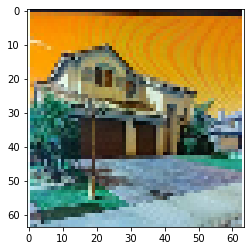

In [17]:
image_sample=cv2.imread('/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/4.jpg')
sample_resized=cv2.resize(image_sample,(64,64))
plt.imshow(sample_resized)

Preprocessing the data so that the trained model can predict

In [18]:
X1_final=np.zeros(4,dtype='float32')
X1_final[0]=attr_sample['n_citi']/citim
X1_final[1]=attr_sample['bed']/bm
X1_final[2]=attr_sample['bath']/bathm
X1_final[3]=attr_sample['sqft']/sqftm
y_ground_truth=attr_sample['price']

In [19]:
X2_final=sample_resized/255.0

In [20]:
print(X1_final.shape," ",X2_final.shape)

(4,)   (64, 64, 3)


In [21]:
y_pred=model.predict([np.reshape(X1_final,(1,4)),np.reshape(X2_final,(1,64,64,3))])

In [22]:
print("Actual price: ",attr_sample['price'].values)
print("Predicted price: ",y_pred*pricem)

Actual price:  [385100]
Predicted price:  [[548042.77420044]]
